# ASTR3110 Tutorial 11: CNNs Continued
Tutorial 11 of the 'Data Science Techniques in Astrophysics' course at Macquarie University.

## Learning outcomes from this tutorial

 * Learn how to setup an image dataset so it is fully loaded into memory.
 * Visualise the innards of a CNN

## Setup for Google Drive

Today we will be operating on a dataset of animal images, so start by linking to your Google drive. The dataset is available at this link: [[animals.tar.gz](https://drive.google.com/file/d/1qhm0WBjA03Uq57OsaMmurF0Qve1OmGO6/view?usp=sharing)]. Please download to your Google drive and extract to a ```DATA/``` folder that can bee seen from your notebook.

```
# Link to Google drive
from google.colab import drive
drive.mount('/content/gdrive')

# Mount your drive
cd gdrive/'My Drive'

# Unpack the dataset
!tar -xzvf animals.tar.gz
mv animals DATA/
```

## Loading the data into a memory structure

This tutorial will furnish you with simple tools that will make loading and pre-processing your data easier. These tools are designed to help load your data into memory for faster processing time (but of course do not work for datasets that will not fit into memory). They have been adapted from the [PyImageSearch Blog](https://www.pyimagesearch.com/blog/).

Make sure you have retrieved the ```CNN_utils``` directory from the [Github Repository](https://github.com/MQ-ASTR3110-2020/ASTR3110_Tutorial_Notebooks) or downloaded it from [this link ](https://drive.google.com/file/d/1Ja28jawIQRJZ4UZPtHMtzJ4rpVbY2M7C/view?usp=sharing).

Let's start by importing the standar modules and helper classes.

In [1]:
# Import necessary modules
import os
import shutil

# Import the helper tools
from CNN_utils import SimpleDatasetLoader
from CNN_utils import SimplePreprocessor
from CNN_utils import ShallowNet
from CNN_utils import ImageToArrayPreprocessor

Using TensorFlow backend.
/home/cpurcell/.virtualenvs/dl_tf1.12p/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cpurcell/.virtualenvs/dl_tf1.12p/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cpurcell/.virtualenvs/dl_tf1.12p/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cp

As before, the train-validation-test split has already been done, so we just need to create paths that point to each directory.

In [2]:
# Create the paths to the three datasets
dataDir = "DATA/animals"
trainPath = os.path.join(dataDir, "train")
validPath = os.path.join(dataDir, "valid")
testPath = os.path.join(dataDir, "test")

The imutils module can help us find only images in a directory.

In [3]:
from imutils import paths

# Get the paths to all the images
trainPaths = list(paths.list_images(trainPath))
validPaths = list(paths.list_images(validPath))
testPaths = list(paths.list_images(testPath))

# Print an example
print(trainPaths[:5])

['DATA/animals/train/dog/dog.640.jpg', 'DATA/animals/train/dog/dog.94.jpg', 'DATA/animals/train/dog/dog.21.jpg', 'DATA/animals/train/dog/dog.346.jpg', 'DATA/animals/train/dog/dog.937.jpg']


The utilities are provided as python *classes*. These are *objects* that can themselves conain both variables and functions (called 'methods' if they are inside a class). We can make an *instance* of a class by calling it like a function.

The ```SimpleDatasetLoader``` can take an optional list of preprocessor classes that apply some operation to the data in order. We will make instances of ```SimplePreprocessor``` (which resizes images) and ```ImageToArrayPreprocessor``` (which puts image arrays in the format Keras is expecting).

In [4]:
# Initialize preprocessors to resize images
size = 100
sp = SimplePreprocessor(size, size)

# Initialise to convert image format PIL -> Numpy
iap = ImageToArrayPreprocessor()

# Create a dataset loader object to load images and apply preprocessing
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])

The actual loading is done by calling the ```load()``` method of the ```SimpleDatasetLoader``` instance.

In [5]:
# Load the training data from disk into memory
(dataTrain, labelsTrain) = sdl.load(trainPaths, verbose=500)

[INFO] processed 500/3500
[INFO] processed 1000/3500
[INFO] processed 1500/3500
[INFO] processed 2000/3500
[INFO] processed 2500/3500
[INFO] processed 3000/3500
[INFO] processed 3500/3500


In [6]:
# Load the validation data from disk into memory
dataValid, labelsValid = sdl.load(validPaths, verbose=500)

[INFO] processed 500/1000
[INFO] processed 1000/1000


In [7]:
# Load the test data from disk into memory
dataTest, labelsTest = sdl.load(testPaths, verbose=100)

[INFO] processed 100/500
[INFO] processed 200/500
[INFO] processed 300/500
[INFO] processed 400/500
[INFO] processed 500/500


We still need to convert our data intensity ranges from [0, 255] to [0, 1].

In [8]:
# Scale the data intesnity from 0-1
dataTrain = dataTrain.astype("float") / 255.0
dataValid = dataValid.astype("float") / 255.0
dataTest = dataTest.astype("float") / 255.0

# Feedback to user
print("Training array is shape:",  dataTrain.shape)
print("Validation array is shape:",  dataValid.shape)
print("Testing array is shape:",  dataTest.shape)

Training array is shape: (3500, 100, 100, 3)
Validation array is shape: (1000, 100, 100, 3)
Testing array is shape: (500, 100, 100, 3)


Now each image dataset is in a 4D array with the 1st dimension indexing the image number. The label arrays have also been loaded by the ```SimpleDatasetLoader``` and we need to convert these to one-hot vectors as before.

In [9]:
# Labels are arrays of words
labelsTrain

array(['dog', 'dog', 'dog', ..., 'cat', 'cat', 'cat'], dtype='<U5')

In [10]:
from sklearn.preprocessing import LabelBinarizer

# Convert to one-hot vectors
labelsTrain = LabelBinarizer().fit_transform(labelsTrain)
labelsValid = LabelBinarizer().fit_transform(labelsValid)
labelsTest = LabelBinarizer().fit_transform(labelsTest)
labelsTrain

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

Now we can build our network. ```CNN_utils``` comes with some pre-defined networks that you can load with a simple command. For example, the simple 3-layer CNN is defined as ```ShallowNet```:

In [11]:
from CNN_utils import ShallowNet

ShallowNet??

And the CNN from last week is defined as ```SimpleNet```:

In [12]:
from CNN_utils import SimpleNet

SimpleNet??

Look at the code in the files to see how these are implemented. Note that the ```__init__.py``` make the ```CNN_utils``` directory into a Module and points the way to the utility classess. 

We can load a network with a single call, making it easy to swap out CNN architectures with a single change.

In [13]:
from keras.optimizers import SGD

# Set the number of classes from the length of a one-hot vector
nClasses = len(labelsTrain[0])

# Load the model architecture
model = SimpleNet.build(width=size, height=size, depth=3, classes=nClasses)

# Set the optimiser algorithm and compile the model
opt = SGD(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

Now we are ready to train the network. This should be significantly faster than the generator method.

In [14]:
# Set the batch size
batchSize = 32

# Guess the number of epochs
nEpochs = 200

# Train the network
H = model.fit(dataTrain, labelsTrain, 
              validation_data=(dataValid, labelsValid),
              batch_size=batchSize, epochs=nEpochs, verbose=1)

Train on 3500 samples, validate on 1000 samples
Epoch 1/200
3500/3500 [==============================] - 3s 942us/step - loss: 1.0793 - acc: 0.4031 - val_loss: 1.0645 - val_acc: 0.4000
Epoch 2/200
3500/3500 [==============================] - 1s 366us/step - loss: 1.0644 - acc: 0.4057 - val_loss: 1.0539 - val_acc: 0.3990
Epoch 3/200
3500/3500 [==============================] - 1s 371us/step - loss: 1.0551 - acc: 0.4006 - val_loss: 1.0448 - val_acc: 0.4140
Epoch 4/200
3500/3500 [==============================] - 1s 368us/step - loss: 1.0460 - acc: 0.4117 - val_loss: 1.0357 - val_acc: 0.4520
Epoch 5/200
3500/3500 [==============================] - 1s 369us/step - loss: 1.0359 - acc: 0.4194 - val_loss: 1.0245 - val_acc: 0.4640
Epoch 6/200
3500/3500 [==============================] - 1s 366us/step - loss: 1.0249 - acc: 0.4251 - val_loss: 1.0120 - val_acc: 0.4690
Epoch 7/200
3500/3500 [==============================] - 1s 365us/step - loss: 1.0108 - acc: 0.4360 - val_loss: 0.9978 - val_acc: 

3500/3500 [==============================] - 1s 366us/step - loss: 0.7809 - acc: 0.6197 - val_loss: 0.7695 - val_acc: 0.5990
Epoch 61/200
3500/3500 [==============================] - 1s 370us/step - loss: 0.7777 - acc: 0.6151 - val_loss: 0.7881 - val_acc: 0.6090
Epoch 62/200
3500/3500 [==============================] - 1s 366us/step - loss: 0.7722 - acc: 0.6126 - val_loss: 0.7960 - val_acc: 0.5920
Epoch 63/200
3500/3500 [==============================] - 1s 366us/step - loss: 0.7689 - acc: 0.6177 - val_loss: 0.7990 - val_acc: 0.5780
Epoch 64/200
3500/3500 [==============================] - 1s 378us/step - loss: 0.7683 - acc: 0.6243 - val_loss: 0.7634 - val_acc: 0.6270
Epoch 65/200
3500/3500 [==============================] - 1s 366us/step - loss: 0.7678 - acc: 0.6274 - val_loss: 0.7557 - val_acc: 0.6030
Epoch 66/200
3500/3500 [==============================] - 1s 371us/step - loss: 0.7714 - acc: 0.6203 - val_loss: 0.7682 - val_acc: 0.5980
Epoch 67/200
3500/3500 [=======================

3500/3500 [==============================] - 1s 370us/step - loss: 0.6814 - acc: 0.6743 - val_loss: 0.8887 - val_acc: 0.5500
Epoch 120/200
3500/3500 [==============================] - 1s 366us/step - loss: 0.6904 - acc: 0.6746 - val_loss: 0.8616 - val_acc: 0.5570
Epoch 121/200
3500/3500 [==============================] - 1s 369us/step - loss: 0.6760 - acc: 0.6800 - val_loss: 0.7195 - val_acc: 0.6460
Epoch 122/200
3500/3500 [==============================] - 1s 373us/step - loss: 0.6832 - acc: 0.6694 - val_loss: 0.7064 - val_acc: 0.6450
Epoch 123/200
3500/3500 [==============================] - 1s 365us/step - loss: 0.6775 - acc: 0.6706 - val_loss: 0.7515 - val_acc: 0.5940
Epoch 124/200
3500/3500 [==============================] - 1s 369us/step - loss: 0.6731 - acc: 0.6803 - val_loss: 0.7038 - val_acc: 0.6470
Epoch 125/200
3500/3500 [==============================] - 1s 370us/step - loss: 0.6794 - acc: 0.6774 - val_loss: 0.7097 - val_acc: 0.6360
Epoch 126/200
3500/3500 [================

3500/3500 [==============================] - 1s 365us/step - loss: 0.5909 - acc: 0.7280 - val_loss: 0.7112 - val_acc: 0.6430
Epoch 179/200
3500/3500 [==============================] - 1s 364us/step - loss: 0.5924 - acc: 0.7260 - val_loss: 0.7356 - val_acc: 0.6480
Epoch 180/200
3500/3500 [==============================] - 1s 374us/step - loss: 0.5829 - acc: 0.7294 - val_loss: 0.6984 - val_acc: 0.6610
Epoch 181/200
3500/3500 [==============================] - 1s 368us/step - loss: 0.5818 - acc: 0.7343 - val_loss: 0.6937 - val_acc: 0.6580
Epoch 182/200
3500/3500 [==============================] - 1s 380us/step - loss: 0.5838 - acc: 0.7371 - val_loss: 0.7741 - val_acc: 0.6190
Epoch 183/200
3500/3500 [==============================] - 1s 379us/step - loss: 0.5862 - acc: 0.7289 - val_loss: 0.7225 - val_acc: 0.6580
Epoch 184/200
3500/3500 [==============================] - 1s 371us/step - loss: 0.5744 - acc: 0.7374 - val_loss: 0.6985 - val_acc: 0.6670
Epoch 185/200
3500/3500 [================

# Evaluation 

Evaluate and plot curves (see last week's notes for details).

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set larger font sizes
mpl.rcParams["font.size"] = 12.0

def plot_train_curves(H):

    # Create the figure
    fig = plt.figure(figsize=(14., 6.))
    
    # Sub-plot for the loss curves
    ax1 = fig.add_subplot(1,2,1)    
    epoch = range(1, len(H["loss"])+1)
    ax1.step(epoch, H["loss"], where="mid", label="Train Loss")
    ax1.step(epoch, H["val_loss"], where="mid", label="Valid Loss")
    ax1.legend(loc="best", shadow=False, fontsize="medium")
    ax1.set_title("Model Loss [Epoch {:d}]".format(epoch[-1]))
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epoch")
    
    # Sub-plot for the accuracy curves
    ax2 = fig.add_subplot(1,2,2)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.step(epoch, H["acc"], where="mid", label="Train Accuracy")
    ax2.step(epoch, H["val_acc"], where="mid", label="Valid Accuracy")
    ax2.legend(loc="lower right", shadow=False, fontsize="medium")
    ax2.set_title("Model Accuracy [Epoch {:d}]".format(epoch[-1]))
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Epoch")

    # Apply nice formatting
    ax1.tick_params(pad=7)
    for line in ax1.get_xticklines() + ax1.get_yticklines():
        line.set_markeredgewidth(1)
        ax2.tick_params(pad=7)
    for line in ax2.get_xticklines() + ax2.get_yticklines():
        line.set_markeredgewidth(1)
        plt.tight_layout()

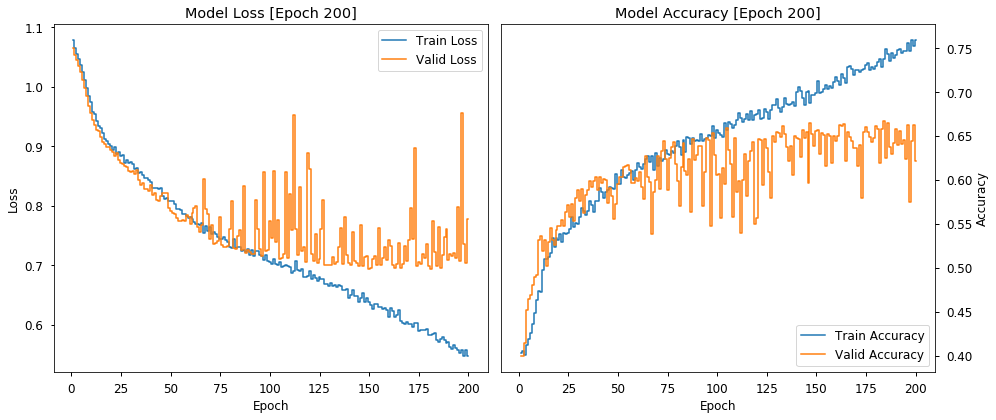

In [19]:
# Plot the training curves
plot_train_curves(H.history)

Here we can see a clear case of over-fitting after ~60 epochs. In this case we shoud have stopped at 60 epochs and used this as our best model. 

In [20]:
from sklearn.metrics import classification_report

# Evaluate the network
predictions = model.predict(dataTest, batch_size=32)
print(classification_report(labelsTest.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=["cat", "dog", "panda"]))

              precision    recall  f1-score   support

         cat       0.58      0.79      0.67       200
         dog       0.61      0.43      0.50       200
       panda       0.82      0.70      0.76       100

    accuracy                           0.63       500
   macro avg       0.67      0.64      0.64       500
weighted avg       0.64      0.63      0.62       500



In [22]:
from sklearn.metrics import confusion_matrix
cmatrix = confusion_matrix(labelsTest.argmax(axis=1), predictions.argmax(axis=1))
print(cmatrix)

[[158  36   6]
 [105  86   9]
 [ 11  19  70]]
